In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

8.0%

100.1%

Extracting ../Data\MNIST\raw\train-images-idx3-ubyte.gz


39.7%%

Extracting ../Data\MNIST\raw\train-labels-idx1-ubyte.gz


180.4%

Extracting ../Data\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ../Data\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [5]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)   
        loss = criterion(y_pred, y_train)
 
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 

epoch:  0  batch:  600 [  6000/60000]  loss: 0.20879607  accuracy:  78.350%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.58846974  accuracy:  85.558%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.02818724  accuracy:  88.683%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01245512  accuracy:  90.508%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01122092  accuracy:  91.613%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.01107820  accuracy:  92.419%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.07323463  accuracy:  93.005%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00166770  accuracy:  93.523%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00080059  accuracy:  93.950%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00152524  accuracy:  94.292%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.03142567  accuracy:  97.983%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.33093292  accuracy:  97.742%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.24226348  accuracy:  97.761%
epoch:  1  b

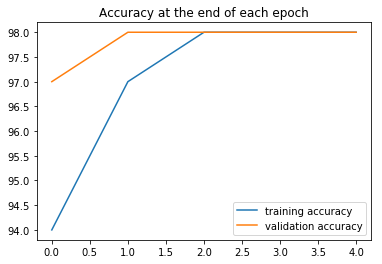

In [8]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [9]:
#evaluate : 
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [10]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9847/10000 =  98.470%
